# **Hands On Graph Neural Networks Using Python  -  CHAPTER 12**

- This code implements and trains a Graph Neural Network (GNN) model using PyTorch Geometric.

- It includes three model classes: `GCNConv`, `GATModel`, and `HANModel`, with `HANModel` being used in the training loop. The dataset is loaded from the DBLP collection, and a `HANModel` is initialized and trained for 101 epochs.

- During training, the model's performance is evaluated using accuracy, precision, recall, and F1 score on both training and validation sets every 20 epochs. Additionally, model checkpoints are saved periodically.

- After training, the model is tested on a separate test set, and final metrics are computed. The training loss is plotted against epochs to visualize the learning process. The `compute_metrics` function calculates precision, recall, and F1 score using `precision_recall_fscore_support` from scikit-learn.

In [39]:
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.nn import to_hetero
from torch_geometric.datasets import DBLP
from torch_geometric.data import HeteroData
from torch_geometric.utils import add_self_loops, degree
from sklearn.metrics import precision_recall_fscore_support
from torch_geometric.nn import MessagePassing, GATConv, HANConv
import warnings
warnings.filterwarnings("ignore")

### **GCNConv Class**

 This class defines a `custom graph convolution layer` using message passing. It performs graph convolution by first adding self-loops to the edges of the graph, then applying a linear transformation to the node features. The degree of each node is used to compute normalization factors, which adjust the contribution of each neighboring node to the convolution process. The message function defines how messages are aggregated from neighboring nodes, using these normalization factors.

In [11]:
class GCNConv(MessagePassing):
    def __init__(self, dim_in, dim_h):
        super().__init__(aggr='add')
        self.linear = nn.Linear(dim_in, dim_h, bias=False)

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        x = self.linear(x)
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        out = self.propagate(edge_index, x=x, norm=norm)
        return out

    def message(self, x, norm):
        return norm.view(-1, 1) * x

### **Graph Attention Network Model Class**

This class represents a `Graph Attention Network (GAT) model`. It utilizes the GATConv layer to compute node embeddings with attention mechanisms. The model takes node features and edge indices as input, applies the GAT layer to capture the attention-based relationships between nodes, and then uses a linear layer to produce the final output features. This model is designed to handle heterogenous graphs with multiple types of relationships.

In [12]:
class GATModel(nn.Module):
    def __init__(self, dim_h, dim_out):
        super().__init__()
        self.conv = GATConv((-1, -1), dim_h, add_self_loops=False)
        self.linear = nn.Linear(dim_h, dim_out)

    def forward(self, x_dict, edge_index_dict):
        h = self.conv(x_dict['author'], edge_index_dict[('author', 'metapath_0', 'author')]).relu()
        h = self.linear(h)
        return h

### **Heterogeneous Graph Attention Network Model Class**

This class defines a `Heterogeneous Graph Attention Network (HAN) model`. It leverages the HANConv layer to process heterogeneous graphs, where nodes and edges can have different types. The HANConv layer performs attention-based aggregation across different types of edges and nodes. The model includes a linear layer to produce the final output features after processing through the HAN layer. This class is specifically designed to handle complex graph structures with diverse node and edge types.

In [13]:
class HANModel(nn.Module):
    def __init__(self, dim_in, dim_out, dim_h=128, heads=8):
        super().__init__()
        self.han = HANConv(dim_in, dim_h, heads=heads, dropout=0.6, metadata=data.metadata())
        self.linear = nn.Linear(dim_h, dim_out)

    def forward(self, x_dict, edge_index_dict):
        out = self.han(x_dict, edge_index_dict)
        out = self.linear(out['author'])
        return out

### **Prepare data and models**

In [14]:
dataset = DBLP('.')
data = dataset[0]
data['conference'].x = torch.zeros(20, 1)

gcn_model = GCNConv(dim_in=16, dim_h=32)
gat_model = GATModel(dim_h=64, dim_out=4)
han_model = HANModel(dim_in=-1, dim_out=4)

### **Ensure correct initialization and forwarding**

In [15]:
optimizer = torch.optim.Adam(han_model.parameters(), lr=0.001, weight_decay=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data, han_model = data.to(device), han_model.to(device)

### **Print Keys**

In [22]:
print("\n\nKeys in edge_index_dict:\n", data.edge_index_dict.keys(), "\n\n")



Keys in edge_index_dict:
 dict_keys([('author', 'to', 'paper'), ('paper', 'to', 'author'), ('paper', 'to', 'term'), ('paper', 'to', 'conference'), ('term', 'to', 'paper'), ('conference', 'to', 'paper')]) 




### **Training**

In [23]:
@torch.no_grad()
def test(mask, model, data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)
    acc = (pred[mask] == data['author'].y[mask]).sum() / mask.sum()
    return float(acc), pred[mask].cpu().numpy()

def compute_metrics(preds, labels):
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return precision, recall, f1

# Training loop
train_losses = []
for epoch in range(101):
    han_model.train()
    optimizer.zero_grad()
    out = han_model(data.x_dict, data.edge_index_dict)
    mask = data['author'].train_mask
    loss = F.cross_entropy(out[mask], data['author'].y[mask])
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    if epoch % 20 == 0:
        train_acc, train_preds = test(data['author'].train_mask, han_model, data)
        val_acc, val_preds = test(data['author'].val_mask, han_model, data)

        train_precision, train_recall, train_f1 = compute_metrics(train_preds, data['author'].y[data['author'].train_mask].cpu().numpy())
        val_precision, val_recall, val_f1 = compute_metrics(val_preds, data['author'].y[data['author'].val_mask].cpu().numpy())
        print("\n\n------------------------------------------------------------------------------------------------------------")
        print(f'Epoch: {epoch:>3} | Train Loss: {loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%')
        print(f'\n    * Train Precision: {train_precision:.2f},\n    * Train Recall: {train_recall:.2f},\n    * Train F1: {train_f1:.2f}')
        print(f'    * Val Precision: {val_precision:.2f},\n    * Val Recall: {val_recall:.2f},\n    * Val F1: {val_f1:.2f}')

        # Save model checkpoint
        torch.save(han_model.state_dict(), f'han_model_epoch_{epoch}.pth')



------------------------------------------------------------------------------------------------------------
Epoch:   0 | Train Loss: 1.3803 | Train Acc: 36.75% | Val Acc: 30.00%

    * Train Precision: 0.56,
    * Train Recall: 0.37,
    * Train F1: 0.27
    * Val Precision: 0.18,
    * Val Recall: 0.30,
    * Val F1: 0.18


------------------------------------------------------------------------------------------------------------
Epoch:  20 | Train Loss: 1.1549 | Train Acc: 89.75% | Val Acc: 67.25%

    * Train Precision: 0.91,
    * Train Recall: 0.90,
    * Train F1: 0.88
    * Val Precision: 0.75,
    * Val Recall: 0.67,
    * Val F1: 0.61


------------------------------------------------------------------------------------------------------------
Epoch:  40 | Train Loss: 0.7812 | Train Acc: 95.75% | Val Acc: 71.50%

    * Train Precision: 0.96,
    * Train Recall: 0.96,
    * Train F1: 0.96
    * Val Precision: 0.77,
    * Val Recall: 0.71,
    * Val F1: 0.68


--------------

### **Final Test**

In [38]:
test_acc, test_preds = test(data['author'].test_mask, han_model, data)
test_precision, test_recall, test_f1 = compute_metrics(test_preds, data['author'].y[data['author'].test_mask].cpu().numpy())
print(f'\nTest accuracy: {test_acc*100:.2f}%')
print("\n\n------------------------------------------------------------------------------------------------------------")
print(f'\n    * Test Precision: {test_precision:.2f},\n    * Test Recall: {test_recall:.2f},\n    * Test F1: {test_f1:.2f}')

Accuracy: 66.46%


### **Plot training loss**

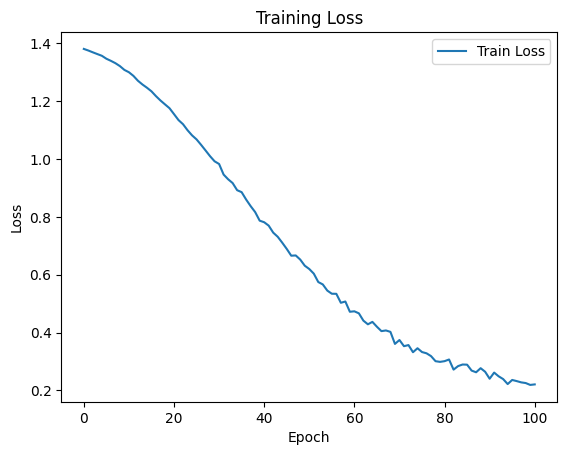

In [24]:
plt.figure()
plt.plot(range(101), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()